In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

data = pd.read_csv("R.csv")

In [12]:
labels = data.copy()

feature_headings = [
    "d1","d2","d3","d4","d5","d6","First Layer","Second Layer"
]

features = labels[feature_headings]
labels = labels[[c for c in labels.columns if c not in feature_headings]]


In [13]:
materials = list(set([*features["First Layer"].unique(), *features["Second Layer"].unique()]))

mapping = {
    v: i for (i,v) in enumerate(materials)
}

features["First Layer"] = features["First Layer"].apply(lambda x: mapping[x])
features["Second Layer"] = features["Second Layer"].apply(lambda x: mapping[x])


feature_array = np.array(features)
feature_array

array([[30, 40, 60, ..., 40, 11,  9],
       [50, 50, 50, ..., 50, 18,  0],
       [20, 10, 60, ..., 60,  7, 27],
       ...,
       [40, 20, 30, ..., 30, 18, 20],
       [40, 40, 50, ..., 40,  3, 31],
       [60, 60, 10, ..., 30, 14, 16]])

In [14]:
ml_model = keras.Sequential([
    keras.layers.Dense(8),
    keras.layers.Dense(400),
    keras.layers.Dense(400),
    keras.layers.Dense(400),
    keras.layers.Dense(250),
    keras.layers.Dense(len(labels.columns))
])

ml_model.compile(loss= keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam())

In [15]:
ml_model.fit(features, labels, epochs=10, validation_split=0.1)

Epoch 1/10
844/844 [==============================] - 4s 5ms/step - loss: 0.2757 - val_loss: 0.1246
Epoch 2/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1242 - val_loss: 0.1179
Epoch 3/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1196 - val_loss: 0.1160
Epoch 4/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1179 - val_loss: 0.1163
Epoch 5/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1180 - val_loss: 0.1177
Epoch 6/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1171 - val_loss: 0.1149
Epoch 7/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1159 - val_loss: 0.1141
Epoch 8/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1162 - val_loss: 0.1132
Epoch 9/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1155 - val_loss: 0.1127
Epoch 10/10
844/844 [==============================] - 4s 4ms/step - loss: 0.1146 - val_loss: 0.1133

In [16]:
mapping["SiO2"], mapping["Co"]

(5, 9)

1/1 [==============================] - 0s 66ms/step


/home/clk/repos/l2-transfer-matrix-method/.venv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


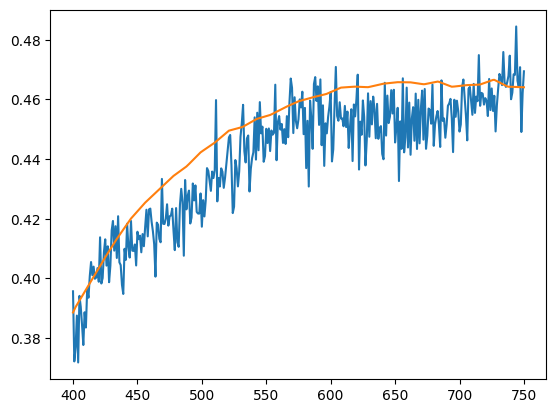

In [17]:
from transfer_matrix_method import reflectance
from transfer_matrix_method.reflectance import Layer
from transfer_matrix_method.refractive_index import MaterialRefractiveIndex
import matplotlib.pyplot as plt

sio2 = MaterialRefractiveIndex("SiO2")
Co = MaterialRefractiveIndex("Co")

spec = [10,10,10,20,20,20, 9,5]

layers = [Layer(t*1e-9, MaterialRefractiveIndex(materials[spec[6:][i%2]])) for t,i in enumerate(spec[:6])]

x = np.arange(400,751,1)
y1 = ml_model.predict([spec]).T
y2 = [reflectance(layers,x_i*1e-9)[0] for x_i in x]

fig,ax = plt.subplots()

ax.plot(x,list(zip(y1,y2)))